## 1. Import Library

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google.colab import drive
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 2. Mount Google Drive & Load Dataset

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Dataset_Skripsi/gabungan_data_new.csv')
df.head()


Mounted at /content/drive


,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1923590616400920953,Sat May 17 04:21:05 +0000 2025,0,Dari grafik di atas jumlah orang yang terkena ...,1923594597244207395,NaN,SecarikKebaikan,in,NaN,0,0,0,https://x.com/SecarikKebaikan/status/192359459...,1920332599278645248,SecarikKebaikan
1,1923566815403442224,Sat May 17 04:17:49 +0000 2025,0,@KheyL4_8 Pentingnya menjaga kesehatan mental ...,1923593777488474370,NaN,KheyL4_8,in,NaN,0,0,0,https://x.com/rynzifary/status/192359377748847...,1323854772374392832,rynzifary
2,1923589476154233192,Sat May 17 04:14:23 +0000 2025,0,@ur__imagination Gpp kak daripada dipendam nta...,1923592912484569148,NaN,ur__imagination,in,NaN,0,0,0,https://x.com/infjawa/status/1923592912484569148,1876946563202981888,infjawa
3,1923333762714112357,Sat May 17 04:13:41 +0000 2025,0,@coconutmocha26 @Ahnrahma1 @monokorobogawl Kad...,1923592735438798950,NaN,coconutmocha26,in,NaN,0,2,0,https://x.com/ShanksSidik/status/1923592735438...,1554787048577728512,ShanksSidik
4,1923592300715999373,Sat May 17 04:11:57 +0000 2025,0,lagu jj tuh ada season masing masing deh paham...,1923592300715999373,NaN,NaN,in,NaN,0,0,0,https://x.com/netimpuknih/status/1923592300715...,1870742857566633984,netimpuknih


## 3. Pra-Pemrosesan Teks

In [ ]:
# Drop kolom tidak relevan
df.drop(columns=['conversation_id_str','favorite_count', 'id_str', 'image_url','in_reply_to_screen_name',
                 'lang','location','quote_count','reply_count','retweet_count','tweet_url','username'], inplace=True, errors='ignore')

In [ ]:
# Rename kolom
df.rename(columns={'index': 'NO', 'user_id_str' : 'Tweet_ID','created_at': 'Datetime', 'full_text': 'Text'}, inplace=True)

In [ ]:
# Bersihkan teks
def clean_text(text):
    text = re.sub(r'@[\w]+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('<.*?>', ' ', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    text = ' '.join(text.split())
    return text

df['clean'] = df['Text'].astype(str).apply(clean_text)

In [ ]:
# Tokenisasi
from nltk.tokenize import RegexpTokenizer
regexp = RegexpTokenizer(r'\w+')
df['Token'] = df['clean'].apply(regexp.tokenize)

In [ ]:
# Normalisasi
normalized_word = pd.read_csv('/content/drive/MyDrive/Dataset_Skripsi/File Normalisasi/normalisasi_new.csv', encoding='latin1')
normalized_dict = dict(zip(normalized_word.iloc[:,0], normalized_word.iloc[:,1]))

def normalized_term(doc):
    return [normalized_dict.get(term, term) for term in doc]

df['Normalisasi'] = df['Token'].apply(normalized_term)

In [ ]:
# Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword = set(stopwords.words('indonesian'))
txt_stopword = pd.read_csv('/content/drive/MyDrive/Dataset_Skripsi/File Stopwords/stopwords_final.txt', names=['stopwords'], header=None)
stopword.update(txt_stopword['stopwords'][0].split())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Hapus stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopword]

df['Stopwords'] = df['Normalisasi'].apply(remove_stopwords)

In [ ]:
!pip install Sastrawi swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 10.6 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=d9a678558d02117293d658e3f813f47b9c5b3292176bd8dbb21f6daadea2ed6d
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


In [ ]:
# Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

stemmer = StemmerFactory().create_stemmer()
term_dict = {}

for doc in df['Stopwords']:
    for term in doc:
        if term not in term_dict:
            term_dict[term] = stemmer.stem(term)

def stem_document(doc):
    return [term_dict[t] for t in doc]

df['Stemmer'] = df['Stopwords'].swifter.apply(stem_document)
df['Final_Text'] = df['Stemmer'].apply(lambda x: ' '.join(x))

## 4. Aspek Kesehatan Mental Dan Label Sentimen

In [ ]:
from collections import defaultdict
import pandas as pd

# Baca CSV
df_kamus = pd.read_csv('/content/drive/MyDrive/Dataset_Skripsi/File Aspek/kamus_aspek_mental.csv')

# Ubah menjadi dictionary
kamus_awal = defaultdict(list)
for _, row in df_kamus.iterrows():
    aspek = row['aspek']
    keyword = row['keyword']
    kamus_awal[aspek].append(keyword)

# Convert defaultdict ke dict biasa
kamus_awal = dict(kamus_awal)

# Fungsi untuk mendeteksi aspek dan hanya mengembalikan aspek pertama yang ditemukan
def deteksi_aspek(teks, kamus):
    teks = teks.lower()  # Pastikan teks dalam huruf kecil untuk konsistensi
    for aspek, keyword_list in kamus.items():
        for kata in keyword_list:
            if kata in teks:  # Jika kata kunci ditemukan dalam teks
                return aspek  # Kembalikan aspek pertama yang ditemukan
    return 'Tidak Terdeteksi'  # Jika tidak ada aspek yang ditemukan

# Terapkan fungsi ke kolom 'Final_Text' dan simpan hasilnya di kolom 'aspek'
df['Aspek'] = df['Final_Text'].apply(lambda x: deteksi_aspek(str(x).lower(), kamus_awal))

# Simpan hasil ke CSV jika diperlukan
df.to_csv('/content/drive/MyDrive/Dataset_Skripsi/hasil_aspek.csv', index=False)

print("Selesai! Dataset dengan kolom aspek telah diperbarui.")

In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

label_model = "mdhugol/indonesia-bert-sentiment-classification"
model = AutoModelForSequenceClassification.from_pretrained(label_model)
tokenizer = AutoTokenizer.from_pretrained(label_model)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

results = sentiment_pipeline(df['Final_Text'].tolist())
label_map = {'LABEL_0': 1, 'LABEL_1': 0, 'LABEL_2': -1}
df['Label'] = [label_map[i['label']] for i in results]
df.to_csv('Data_Bersih_Bert_Label.csv', index=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
df = df[['Datetime','Tweet_ID','Final_Text', 'Aspek', 'Label']]

## 5. Ekstraksi Fitur (TF-IDF)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=5000)
X = vectorizer.fit_transform(df['Final_Text'])

# Target
y_aspek = df['Aspek']
y_sentimen = df['Label']

In [ ]:
# Ambil nama-nama fitur (kata/ngram)
feature_names = vectorizer.get_feature_names_out()

# Konversi matriks sparse ke DataFrame
df_tfidf = pd.DataFrame(X.toarray(), columns=feature_names)

# Tampilkan 5 baris pertama
selected_cols = ['sehat mental', 'depresi', 'cemas', 'stres']
df_tfidf[selected_cols].head()

,sehat mental,depresi,cemas,stres
0,0.000000,0.116805,0.0,0.171162
1,0.079411,0.162458,0.0,0.238060
2,0.000000,0.128210,0.0,0.187873
3,0.000000,0.079162,0.0,0.000000
4,0.000000,0.060790,0.0,0.000000


## 6. Split Data (Train/Test)

In [ ]:
# Split data (pastikan y_aspek dan y_sentimen dalam bentuk Series)
X_train, X_test, y_aspek_train, y_aspek_test, y_sentimen_train, y_sentimen_test = train_test_split(
    X, y_aspek, y_sentimen, test_size=0.2, random_state=42
)

## 7. Klasifikasi Menggunakan SVM

#ASPEK

In [ ]:
model_aspek = SVC(kernel='rbf', random_state=42)
model_aspek.fit(X_train, y_aspek_train)
y_aspek_pred = model_aspek.predict(X_test)

In [ ]:
# --- Evaluasi model aspek ---
report_aspek = classification_report(y_aspek_test, y_aspek_pred, output_dict=True)
df_aspek_report = pd.DataFrame(report_aspek).transpose()
df_aspek_report = df_aspek_report[['precision', 'recall', 'f1-score', 'support']]
df_aspek_report = df_aspek_report.round(4)

In [ ]:
print("=== Evaluasi Model Aspek ===")
display(df_aspek_report)

=== Evaluasi Model Aspek ===


,precision,recall,f1-score,support
Depresi,0.8861,0.5556,0.6829,126.0000
Dukungan sosial,1.0000,0.0435,0.0833,23.0000
Kecemasan,1.0000,0.0870,0.1600,23.0000
Semangat hidup,0.8333,0.1974,0.3191,76.0000
Stres,0.6352,0.9573,0.7636,351.0000
Tidak Terdeteksi,0.8493,0.6019,0.7045,103.0000
accuracy,0.6923,0.6923,0.6923,0.6923
macro avg,0.8673,0.4071,0.4523,702.0000
weighted avg,0.7570,0.6923,0.6503,702.0000


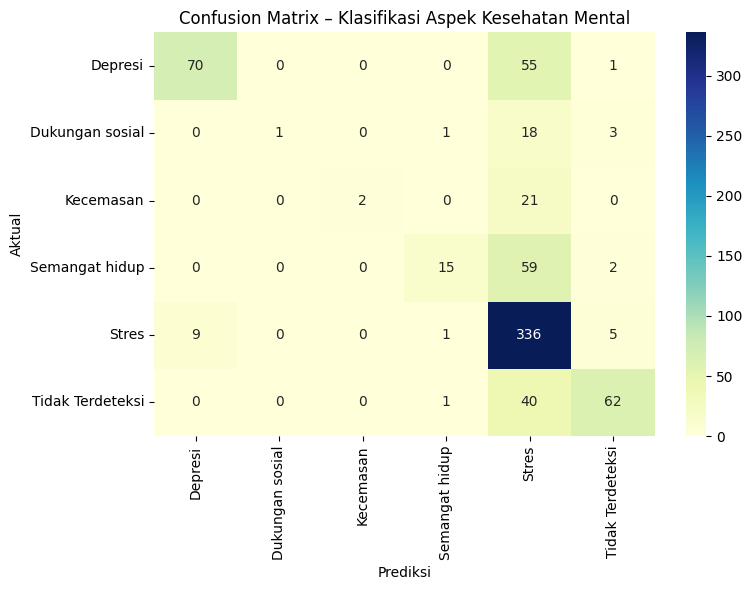

In [ ]:
# =============================
# CONFUSION MATRIX – ASPEK
# =============================

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

label_aspek = sorted(y_aspek_test.unique())

cm_aspek = confusion_matrix(y_aspek_test, y_aspek_pred, labels=label_aspek)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_aspek, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=label_aspek,
            yticklabels=label_aspek)
plt.title("Confusion Matrix – Klasifikasi Aspek Kesehatan Mental")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.tight_layout()
plt.show()

#SENTIMEN

In [ ]:
model_sentimen = SVC(kernel='rbf', random_state=42)
model_sentimen.fit(X_train, y_sentimen_train)
y_sentimen_pred = model_sentimen.predict(X_test)

In [ ]:
# --- Evaluasi model sentimen ---
report_sentimen = classification_report(y_sentimen_test, y_sentimen_pred, output_dict=True)
df_sentimen_report = pd.DataFrame(report_sentimen).transpose()
df_sentimen_report = df_sentimen_report[['precision', 'recall', 'f1-score', 'support']]
df_sentimen_report = df_sentimen_report.round(4)

In [ ]:
print("\n=== Evaluasi Model Sentimen ===")
display(df_sentimen_report)


=== Evaluasi Model Sentimen ===


,precision,recall,f1-score,support
-1,0.7393,0.8459,0.7890,305.0000
0,0.8500,0.6839,0.7580,174.0000
1,0.7230,0.6906,0.7064,223.0000
accuracy,0.7564,0.7564,0.7564,0.7564
macro avg,0.7708,0.7401,0.7511,702.0000
weighted avg,0.7615,0.7564,0.7551,702.0000


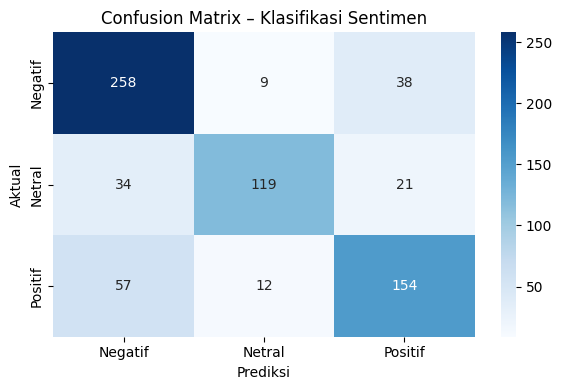

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# =============================
# CONFUSION MATRIX – ASPEK
# =============================
cm_sentimen = confusion_matrix(y_sentimen_test, y_sentimen_pred, labels=[-1, 0, 1])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_sentimen, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'])
plt.title("Confusion Matrix – Klasifikasi Sentimen")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.tight_layout()
plt.show()

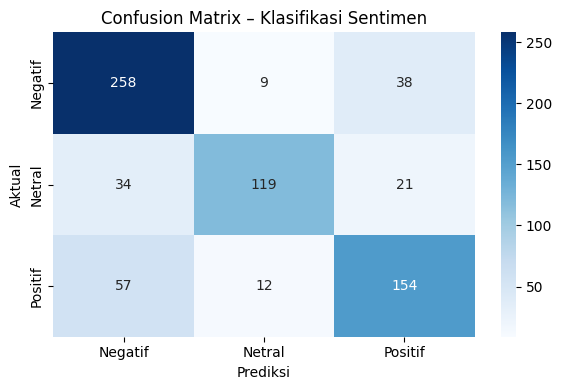

In [ ]:
# =============================
# CONFUSION MATRIX – SENTIMEN
# =============================
cm_sentimen = confusion_matrix(y_sentimen_test, y_sentimen_pred, labels=[-1, 0, 1])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_sentimen, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'])
plt.title("Confusion Matrix – Klasifikasi Sentimen")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.tight_layout()
plt.show()

## 8. Optimasi Hyperparameter dengan PSO

In [ ]:
pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import pyswarms as ps

# Fungsi objektif PSO untuk optimasi SVM
def svm_pso_eval(params, X_train, y_train):
    C = params[:, 0]
    gamma = params[:, 1]
    scores = []
    for i in range(params.shape[0]):
        model = SVC(C=C[i], gamma=gamma[i], kernel='rbf', random_state=42)
        score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
        scores.append(-score)  # PSO minimize, jadi negatif akurasi
    return np.array(scores)

# Fungsi bantu untuk jalankan PSO dan return best model
def optimize_svm_pso(X_train, y_train, bounds, iters=10, swarm_size=10):
    def objective(params):
        return svm_pso_eval(params, X_train, y_train)

    optimizer = ps.single.GlobalBestPSO(n_particles=swarm_size, dimensions=2, options={'c1':0.5, 'c2':0.3, 'w':0.9}, bounds=bounds)
    best_cost, best_pos = optimizer.optimize(objective, iters=iters)
    best_C, best_gamma = best_pos
    print(f"Best params found: C={best_C:.4f}, gamma={best_gamma:.6f}")

    # Latih model terbaik di seluruh data train
    best_model = SVC(C=best_C, gamma=best_gamma, kernel='rbf', random_state=42)
    best_model.fit(X_train, y_train)
    return best_model

# Batas parameter C dan gamma
bounds = ([0.01, 0.0001], [100, 1])  # lower & upper bounds

#Optimasi Untuk Aspek

In [ ]:
print("Optimasi SVM untuk klasifikasi aspek:")
model_aspek = optimize_svm_pso(X_train, y_aspek_train, bounds)

2025-08-05 13:09:00,445 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Optimasi SVM untuk klasifikasi aspek:


pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.763
2025-08-05 13:19:08,363 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.7633625089507442, best pos: [6.53236069e+01 4.38626377e-02]


Best params found: C=65.3236, gamma=0.043863


In [ ]:
# Prediksi hasil optimasi
y_sentimen_pred_opt = model_sentimen.predict(X_test)
y_aspek_pred_opt = model_aspek.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# ============================
# EVALUASI MODEL ASPEK
# ============================
report_aspek_opt = classification_report(y_aspek_test, y_aspek_pred_opt, output_dict=True)
df_aspek_opt = pd.DataFrame(report_aspek_opt).transpose()
df_aspek_opt = df_aspek_opt[['precision', 'recall', 'f1-score', 'support']]
df_aspek_opt = df_aspek_opt.round(4)

print("\n=== Evaluasi Model SVM untuk Aspek (Setelah PSO) ===")
print(df_aspek_opt)


=== Evaluasi Model SVM untuk Aspek (Setelah PSO) ===
                  precision  recall  f1-score   support
Depresi              0.7561  0.7381    0.7470  126.0000
Dukungan sosial      0.8000  0.3478    0.4848   23.0000
Kecemasan            0.8000  0.3478    0.4848   23.0000
Semangat hidup       0.7018  0.5263    0.6015   76.0000
Stres                0.7995  0.8974    0.8456  351.0000
Tidak Terdeteksi     0.7778  0.8155    0.7962  103.0000
accuracy             0.7806  0.7806    0.7806    0.7806
macro avg            0.7725  0.6122    0.6600  702.0000
weighted avg         0.7780  0.7806    0.7706  702.0000


#Optimasi Untuk Sentimen

In [ ]:
print("\nOptimasi SVM untuk klasifikasi sentimen:")
model_sentimen = optimize_svm_pso(X_train, y_sentimen_train, bounds)

2025-08-05 13:19:11,116 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimasi SVM untuk klasifikasi sentimen:


pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.731
2025-08-05 13:26:05,102 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.731292182762771, best pos: [2.54977715e+01 2.14028217e-02]


Best params found: C=25.4978, gamma=0.021403


In [ ]:
# Prediksi dan evaluasi sentimen
y_sentimen_pred = model_sentimen.predict(X_test)
print("Evaluasi Model Sentimen:")
print(classification_report(y_sentimen_test, y_sentimen_pred))

Evaluasi Model Sentimen:
              precision    recall  f1-score   support

          -1       0.77      0.82      0.79       305
           0       0.81      0.73      0.77       174
           1       0.72      0.71      0.71       223

    accuracy                           0.76       702
   macro avg       0.77      0.75      0.76       702
weighted avg       0.76      0.76      0.76       702



In [ ]:
# ============================
# EVALUASI MODEL SENTIMEN
# ============================
report_sentimen_opt = classification_report(y_sentimen_test, y_sentimen_pred_opt, output_dict=True)
df_sentimen_opt = pd.DataFrame(report_sentimen_opt).transpose()
df_sentimen_opt = df_sentimen_opt[['precision', 'recall', 'f1-score', 'support']]
df_sentimen_opt = df_sentimen_opt.round(4)

print("=== Evaluasi Model SVM untuk Sentimen (Setelah PSO) ===")
print(df_sentimen_opt)

=== Evaluasi Model SVM untuk Sentimen (Setelah PSO) ===
              precision  recall  f1-score   support
-1               0.7393  0.8459    0.7890  305.0000
0                0.8500  0.6839    0.7580  174.0000
1                0.7230  0.6906    0.7064  223.0000
accuracy         0.7564  0.7564    0.7564    0.7564
macro avg        0.7708  0.7401    0.7511  702.0000
weighted avg     0.7615  0.7564    0.7551  702.0000


In [ ]:
from sklearn.metrics import accuracy_score

# Hitung akurasi hasil model setelah PSO
acc_sentimen = accuracy_score(y_sentimen_test, y_sentimen_pred_opt)
acc_aspek = accuracy_score(y_aspek_test, y_aspek_pred_opt)

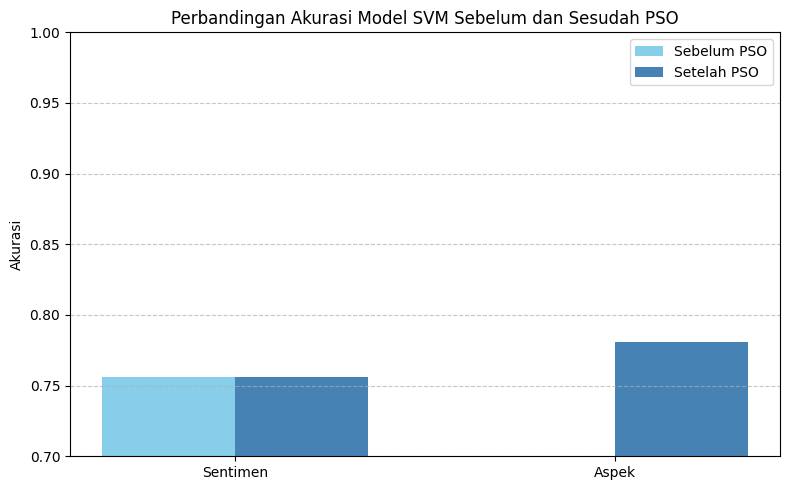

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Misalnya akurasi sebelum dan sesudah optimasi
akurasi_sebelum = {
    'Sentimen': 0.7564,   # ganti dengan nilai aktual dari evaluasi awal
    'Aspek': 0.6923       # ganti juga jika perlu
}

akurasi_sesudah = {
    'Sentimen': acc_sentimen,  # hasil dari accuracy_score setelah PSO
    'Aspek': acc_aspek
}

# Siapkan DataFrame untuk visualisasi
model_names = list(akurasi_sebelum.keys())
before_values = list(akurasi_sebelum.values())
after_values = list(akurasi_sesudah.values())

# Plot diagram batang dua sisi
x = range(len(model_names))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, before_values, width=width, label='Sebelum PSO', color='skyblue')
plt.bar([i + width for i in x], after_values, width=width, label='Setelah PSO', color='steelblue')

# Labeling
plt.xticks([i + width/2 for i in x], model_names)
plt.ylim(0.7, 1.0)
plt.ylabel('Akurasi')
plt.title('Perbandingan Akurasi Model SVM Sebelum dan Sesudah PSO')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

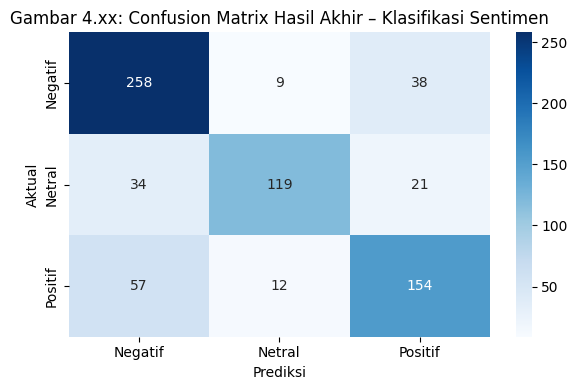

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Confusion Matrix – Sentimen ===
cm_sentimen_opt = confusion_matrix(y_sentimen_test, y_sentimen_pred_opt, labels=[-1, 0, 1])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_sentimen_opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'])
plt.title("Gambar 4.xx: Confusion Matrix Hasil Akhir – Klasifikasi Sentimen")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.tight_layout()
plt.show()

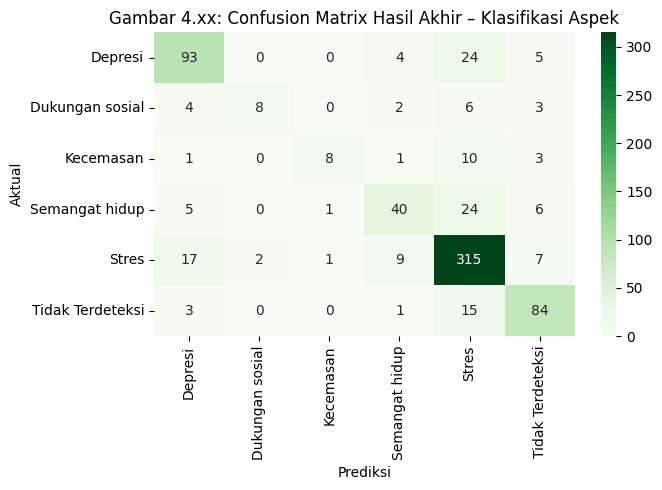

In [ ]:
# === Confusion Matrix – Aspek ===
aspek_labels = sorted(y_aspek_test.unique())  # atau tentukan manual jika kamu punya mapping
plt.figure(figsize=(7, 5))
cm_aspek_opt = confusion_matrix(y_aspek_test, y_aspek_pred_opt, labels=aspek_labels)
sns.heatmap(cm_aspek_opt, annot=True, fmt='d', cmap='Greens',
            xticklabels=aspek_labels,
            yticklabels=aspek_labels)
plt.title("Gambar 4.xx: Confusion Matrix Hasil Akhir – Klasifikasi Aspek")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.tight_layout()
plt.show()

## 9. Visualisasi

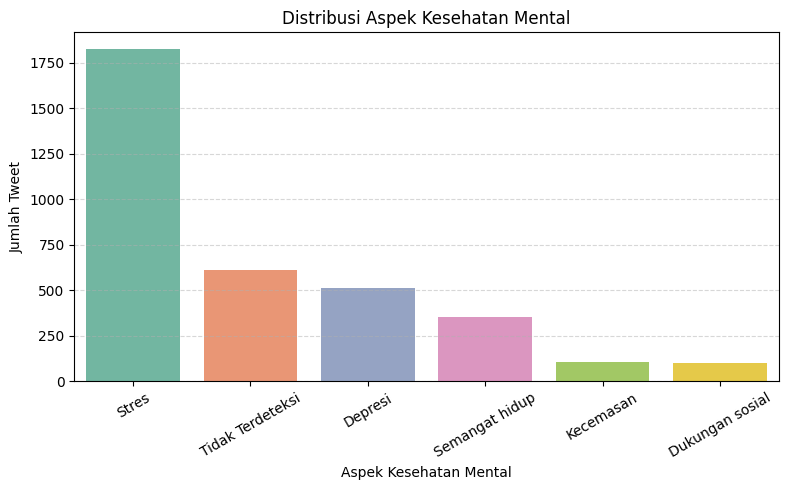

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ukuran gambar
plt.figure(figsize=(8, 5))

# Plot batang distribusi aspek
sns.countplot(x='Aspek', data=df, order=df['Aspek'].value_counts().index, palette='Set2')

# Tambahkan detail
plt.title("Distribusi Aspek Kesehatan Mental")
plt.xlabel("Aspek Kesehatan Mental")
plt.ylabel("Jumlah Tweet")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Tampilkan plot
plt.tight_layout()
plt.show()

#Aspek

In [ ]:
print("Evaluasi Model Aspek:")
print(classification_report(y_aspek_test, y_aspek_pred))

Evaluasi Model Aspek:
                  precision    recall  f1-score   support

         Depresi       0.89      0.56      0.68       126
 Dukungan sosial       1.00      0.04      0.08        23
       Kecemasan       1.00      0.09      0.16        23
  Semangat hidup       0.83      0.20      0.32        76
           Stres       0.64      0.96      0.76       351
Tidak Terdeteksi       0.85      0.60      0.70       103

        accuracy                           0.69       702
       macro avg       0.87      0.41      0.45       702
    weighted avg       0.76      0.69      0.65       702



#Sentimen

In [ ]:
print("Evaluasi Model Sentimen:")
print(classification_report(y_sentimen_test, y_sentimen_pred))

Evaluasi Model Sentimen:
              precision    recall  f1-score   support

          -1       0.77      0.82      0.79       305
           0       0.81      0.73      0.77       174
           1       0.72      0.71      0.71       223

    accuracy                           0.76       702
   macro avg       0.77      0.75      0.76       702
weighted avg       0.76      0.76      0.76       702



#AKURASI

In [ ]:
#Akurasi Total
accuracy_total = accuracy_score(y_aspek_test, y_aspek_pred)
print(f"\nAkurasi Total Prediksi Aspek: {accuracy_total:.2%}")


Akurasi Total Prediksi Aspek: 69.23%


In [ ]:
#Akurasi per Aspek
aspek_list = y_aspek_test.unique()
akurasi_per_aspek = {}

for aspek in aspek_list:
    mask = (y_aspek_test == aspek)
    benar = np.sum(y_aspek_pred[mask] == y_aspek_test[mask])
    total = np.sum(mask)
    akurasi_per_aspek[aspek] = benar / total if total > 0 else 0

# Tampilkan sebagai DataFrame
akurasi_df = pd.DataFrame.from_dict(akurasi_per_aspek, orient='index', columns=['Accuracy'])
akurasi_df['Accuracy (%)'] = akurasi_df['Accuracy'] * 100
akurasi_df = akurasi_df.sort_values(by='Accuracy (%)', ascending=False)

print("\n=== Akurasi per Aspek ===")
print(akurasi_df)


=== Akurasi per Aspek ===
                  Accuracy  Accuracy (%)
Stres             0.957265     95.726496
Tidak Terdeteksi  0.601942     60.194175
Depresi           0.555556     55.555556
Semangat hidup    0.197368     19.736842
Kecemasan         0.086957      8.695652
Dukungan sosial   0.043478      4.347826


#Confussion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

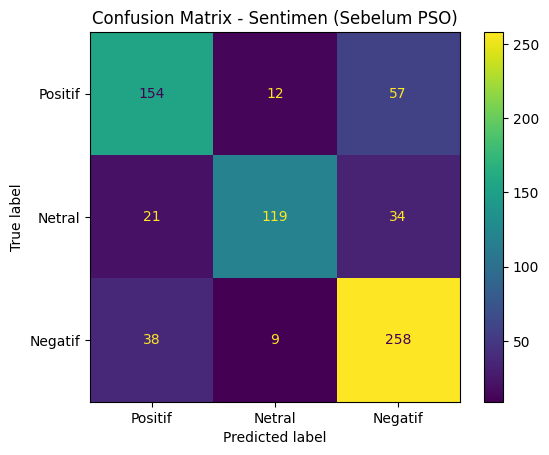

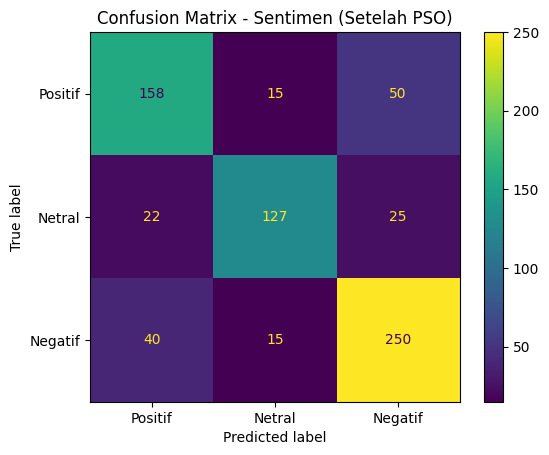

In [ ]:
# SVM sebelum PSO
svm_sentimen = SVC(kernel='rbf', random_state=42)
svm_sentimen.fit(X_train, y_sentimen_train)
y_sentimen_pred_before = svm_sentimen.predict(X_test)

# SVM setelah PSO (sudah dilatih sebelumnya)
y_sentimen_pred_after = model_sentimen.predict(X_test)

# Confusion Matrix: Sebelum PSO
cm_sentimen_before = confusion_matrix(y_sentimen_test, y_sentimen_pred_before, labels=[1, 0, -1])
disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_sentimen_before,
                                     display_labels=["Positif", "Netral", "Negatif"])
disp_before.plot()
plt.title("Confusion Matrix - Sentimen (Sebelum PSO)")
plt.show()

# Confusion Matrix: Setelah PSO
cm_sentimen_after = confusion_matrix(y_sentimen_test, y_sentimen_pred_after, labels=[1, 0, -1])
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_sentimen_after,
                                    display_labels=["Positif", "Netral", "Negatif"])
disp_after.plot()
plt.title("Confusion Matrix - Sentimen (Setelah PSO)")
plt.show()

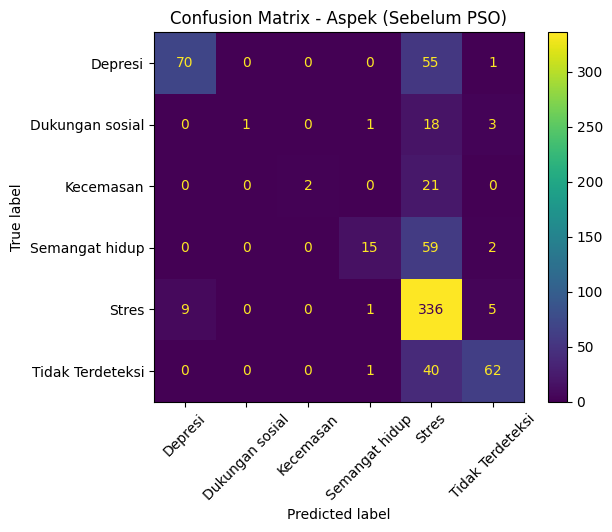

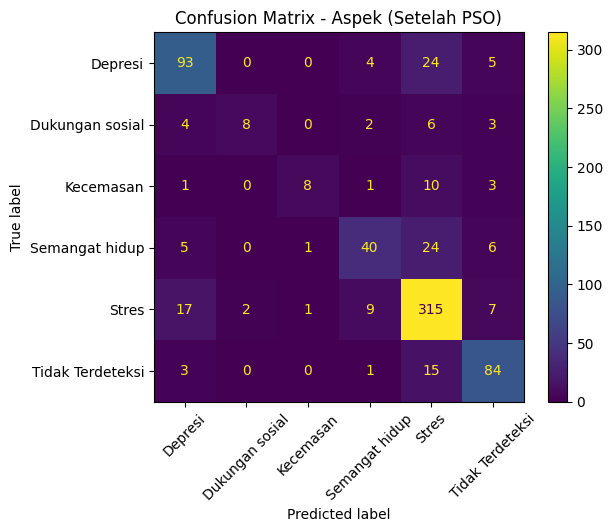

In [ ]:
# SVM sebelum PSO
svm_aspek = SVC(kernel='rbf', random_state=42)
svm_aspek.fit(X_train, y_aspek_train)
y_aspek_pred_before = svm_aspek.predict(X_test)

# SVM setelah PSO (sudah dilatih sebelumnya)
y_aspek_pred_after = model_aspek.predict(X_test)

# Label unik aspek (pastikan urutannya konsisten)
labels_aspek = sorted(list(set(y_aspek_test)))  # atau hardcode kalau ingin urutan tetap
disp_labels_aspek = labels_aspek  # ganti ke nama-nama aspek jika label masih dalam bentuk angka

# Confusion Matrix: Sebelum PSO
cm_aspek_before = confusion_matrix(y_aspek_test, y_aspek_pred_before, labels=labels_aspek)
disp_aspek_before = ConfusionMatrixDisplay(confusion_matrix=cm_aspek_before,
                                           display_labels=disp_labels_aspek)
disp_aspek_before.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Aspek (Sebelum PSO)")
plt.show()

# Confusion Matrix: Setelah PSO
cm_aspek_after = confusion_matrix(y_aspek_test, y_aspek_pred_after, labels=labels_aspek)
disp_aspek_after = ConfusionMatrixDisplay(confusion_matrix=cm_aspek_after,
                                          display_labels=disp_labels_aspek)
disp_aspek_after.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Aspek (Setelah PSO)")
plt.show()

## 10. Visualisasi dan Analisis

#Distribusi Sentimen

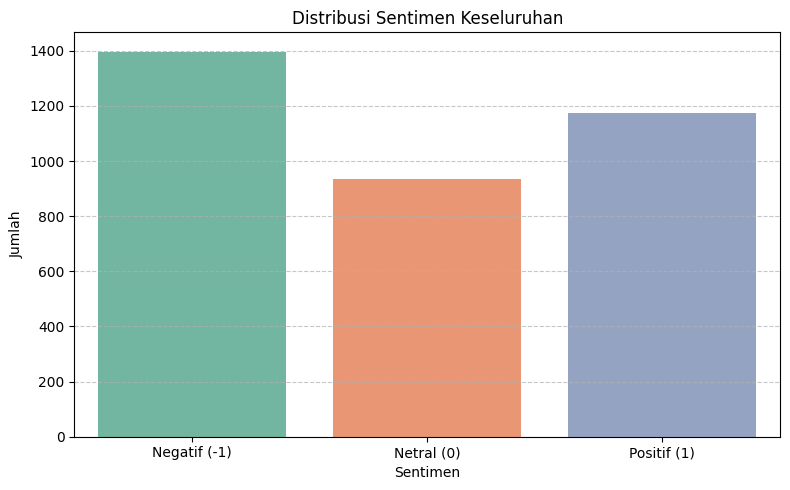

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ganti df dengan nama DataFrame kamu jika berbeda
sentimen_counts = df['Label'].value_counts().sort_index()
sentimen_counts.index = ['Negatif (-1)', 'Netral (0)', 'Positif (1)']

# Plot distribusi sentimen
plt.figure(figsize=(8, 5))
sns.barplot(x=sentimen_counts.index, y=sentimen_counts.values, palette="Set2")
plt.title("Distribusi Sentimen Keseluruhan")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

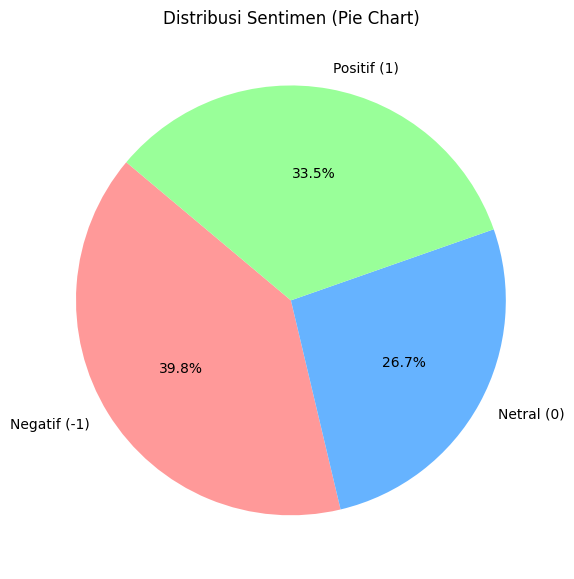

In [ ]:
colors = ['#ff9999', '#66b3ff', '#99ff99']  # Warna untuk negatif, netral, positif
plt.figure(figsize=(6, 6))
plt.pie(sentimen_counts.values, labels=sentimen_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Distribusi Sentimen (Pie Chart)")
plt.tight_layout()
plt.show()

#Distribusi Sentimen Per Aspek

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Pastikan label numerik ke bentuk teks agar mudah dibaca
df['Sentimen'] = df['Label'].replace({1: 'Positif', 0: 'Netral', -1: 'Negatif'})

# Hitung jumlah data per aspek dan sentimen
sentimen_per_aspek = df.groupby(['Aspek', 'Sentimen']).size().reset_index(name='Jumlah')

# Pivot untuk membuat format bertumpuk (stacked bar)
pivot_df = sentimen_per_aspek.pivot(index='Aspek', columns='Sentimen', values='Jumlah').fillna(0)

# Plot bar chart bertumpuk
pivot_df[['Negatif', 'Netral', 'Positif']].plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')

plt.title('Distribusi Sentimen per Aspek')
plt.xlabel('Aspek Kesehatan Mental')
plt.ylabel('Jumlah Tweet')
plt.xticks(rotation=45)
plt.legend(title='Sentimen')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

#Diagram Sentimen Berdasarkan Aspek

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Jika belum ada, buat kolom sentimen dalam bentuk label teks
label_mapping = {-1: 'Negatif', 0: 'Netral', 1: 'Positif'}
df['Label_Sentimen'] = df['Label'].map(label_mapping)

# Ukuran gambar
plt.figure(figsize=(10, 6))

# Plot: Diagram batang bertingkat (grouped bar)
sns.countplot(data=df, x='Aspek', hue='Label_Sentimen',
              order=df['Aspek'].value_counts().index,
              hue_order=['Negatif', 'Netral', 'Positif'],
              palette='Set2')

# Tambahkan label dan judul
plt.title("Sentimen Berdasarkan Aspek Kesehatan Mental")
plt.xlabel("Aspek Kesehatan Mental")
plt.ylabel("Jumlah Tweet")
plt.xticks(rotation=30)
plt.legend(title="Sentimen")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


#WordCloud

Stress

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
df_stres_negatif = df[(df['Aspek'] == 'Stres') & (df['Label'] == -1)]
text_stres_negatif = ' '.join(df_stres_negatif['Final_Text'].astype(str))

wc_stres_negatif = WordCloud(width=800, height=400, background_color='white',
                             stopwords={'sehat', 'mental','banget','kalo','ya','gue','orang'}, colormap='Reds').generate(text_stres_negatif)

plt.figure(figsize=(10, 5))
plt.imshow(wc_stres_negatif, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Stres (Negatif)')
plt.show()

In [ ]:
df_stres_positif = df[(df['Aspek'] == 'Stres') & (df['Label'] == 1)]
text_stres_positif = ' '.join(df_stres_positif['Final_Text'].astype(str))

wc_stres_positif = WordCloud(width=800, height=400, background_color='white',
                             stopwords={'banget','kalo','ya','gue','orang'}, colormap='Greens').generate(text_stres_positif)

plt.figure(figsize=(10, 5))
plt.imshow(wc_stres_positif, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Stres (Positif)')
plt.show()